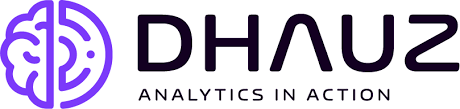

# Evasão de Clientes em telecom - DHAUZ

**O problema: Um de nossos clientes do ramo de telecomunicações nos forneceu uma base dados com vários dados de seus clientes, junto com a informação de se aquele cliente foi "perdido" da base no período dos últimos 31 - 60 dias.**

Minha tarefa como cientista de dados, é fornecer para essa empresa insights sobre o perfil desses clientes "canceladores" junto há uma solução de machine learning robusta, que permita à empresa antecipar a saída dos clientes para à tomada de medidas preventivas.

***obs importante: a empresa está com um prazo apertado para a apresentação dessa solução (48 horas)***

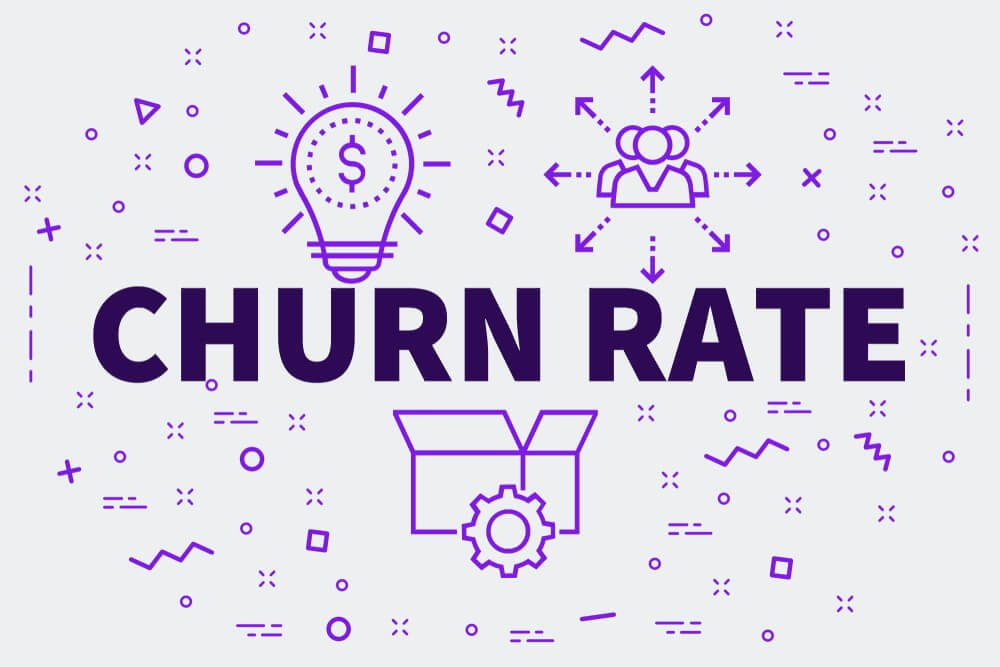

# Região de Imports e Funções

In [36]:
# imports


# basic
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score


# boruta
from boruta import BorutaPy

In [383]:
# funções

# Limpeza de valores Nulos

In [2]:
df = pd.read_csv('churn_challenge_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 99 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       100000 non-null  int64  
 1   churn             100000 non-null  int64  
 2   HHstatin          62077 non-null   object 
 3   actvsubs          100000 non-null  int64  
 4   adjmou            100000 non-null  float64
 5   adjqty            100000 non-null  int64  
 6   adjrev            100000 non-null  float64
 7   adults            76981 non-null   float64
 8   area              99960 non-null   object 
 9   asl_flag          100000 non-null  object 
 10  attempt_Mean      100000 non-null  float64
 11  avg3mou           100000 non-null  int64  
 12  avg3qty           100000 non-null  int64  
 13  avg3rev           100000 non-null  int64  
 14  avg6mou           97161 non-null   float64
 15  avg6qty           97161 non-null   float64
 16  avg6rev           971

***Há um total de 98 colunas do Dataframe***

Com os métodos padrões de exloração, poderíamos levar muito tempo para passar em todas as variáveis, seja criando novas features ou explorando os dados, considerando que nosso cliente tem um prazo de 48 horas para o cumprimento da demanda, irei verificar quais são as colunas com mais ganho de informação logo após etapa de limpeza, assim podemos quebrar os componentes pricipais de previsão e análise, entregando o serviço no prazo

Além disso, as previsões em modelos de ML costumam melhorar bastante quando fazemos uma boa seleção de features em DataFrames esparços como esse.

### Limpeza:

#### HSstatin

Conforme o descritivo, essa variável indica se o cliente tem um perfil de consumo específico, sendo assim, irei substituir os dados nulos com uma categoria própria de perfil de consumo, os clientes Nulos terão um novo perfil de consumo: "Sem perfil"

In [4]:
df['HHstatin'] = df['HHstatin'].fillna('No_profile')

In [5]:
df['HHstatin'].value_counts()

C             39124
No_profile    37923
I             12352
A              4666
B              3246
G              1766
H               923
Name: HHstatin, dtype: int64

#### Adults

Essa variável indica o número de adultos que a casa possuí, para realizar a substituição, irei utilizar a média do número de adultos. Tendo em vista que a coluna possuí uma cardinalidade baixa

In [6]:
# Substituindo com a média

df['adults'].mean() # = 2.53

df['adults'] = df['adults'].fillna(2.53)

In [7]:
df['adults'].value_counts()

2.00    23045
2.53    23019
1.00    22299
3.00    13667
4.00     8803
5.00     4817
6.00     4350
Name: adults, dtype: int64

#### avg6mou, avg6qty, avg6rev

Essas colunas parecem ser importantes, se referem respectivamente a:

* Média mensal de minutos do plano utilizados nos últimos 3 meses.

* Média mensal de ligações nós últimos 3 meses.

* Média mensal de faturamento que o cliente gerou nos últimos 3 meses


Em 100 mil registros temos apenas 2839 clientes nessas situações, suspeito que valores nulos possam indicar clientes que, na verdade, deixaram de usar o plano nos últimos meses, e isso poder ser um dos motivos para o cancelamento do plano, vamos observar a média de "churn" geral e a média entre esses clientes antes de decidir se ficamos ou não com esses dados.

In [8]:
dfaux = df.loc[(df['avg6mou'].isnull()) & (df['avg6qty'].isnull()) & (df['avg6rev'].isnull())]

In [9]:
dfaux['churn'].value_counts()

0    1697
1    1142
Name: churn, dtype: int64

In [10]:
df['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

**Resolução: Observando melhor, é possível ver que existem momentos em que essas colunas têm valor 0, portanto é pouco provável que os valores nulos se tratem de um faturamento/minutos/ligações zerado. E sim de um erro simples de registro na base, minha abordagem será de apagar os valores. Considerando, também que não há um incidência maior de churn nos valores nulos, oque mostra baixo poder inferencial da variável**

In [11]:
df['avg6mou'].value_counts()

0.0       718
1.0       223
11.0      185
65.0      183
5.0       175
         ... 
3351.0      1
3396.0      1
2426.0      1
3554.0      1
5528.0      1
Name: avg6mou, Length: 2941, dtype: int64

In [12]:
df['avg6qty'].value_counts()

0.0       781
44.0      455
30.0      449
49.0      447
53.0      438
         ... 
1147.0      1
1022.0      1
1858.0      1
1299.0      1
2452.0      1
Name: avg6qty, Length: 1376, dtype: int64

In [604]:
dfaux = df.loc[df['avg6rev'] == 1]
dfaux['avg6rev'].value_counts()

1.0    11
Name: avg6rev, dtype: int64

In [13]:
df = df.loc[(df['avg6mou'].notna()) & (df['avg6qty'].notna()) & (df['avg6rev'].notna())]

#### change mou

Essa coluna se refere a diferença percentual de minutos de uso da linha esse mês Vs. A média dos últimos 3 meses

Para preencher os valores nulos de maneira certeira, seria necessário ter o dado com a média mensal de faturamento / uso do mês atual, para comparar com a coluna das médias dos últimos 3 meses, como não possuo esses dados, irei usar de um algorítimo e fornecer algumas informações gerais sobre o faturamento e uso da linha no histórico do cliente, caso o erro seja mais baixo que um preenchimento genérico com a média, irei preencher os nulos com as previsões.

Solução: Quando os valores da coluna change_mou são nulos, as features importantes para preencher seus valores costumam também ser, provavelmente, porque é impossível calcular a diferença do uso atual com o dos últimos meses, quando não há histórico, optei por preencher a coluna change_mou com as previsões do algorítimo, apenas quando o cliente possuí histórico. E excluir os outros casos, tendo em vista que os valores muito provavelmente são nulos devido ao fato do cliente ter cancelado, tirando o poder inferencial dessa variável.

In [14]:
# colunas com dados sobre uso histórico da linha
cols = ['mou_Mean', 'totmrc_Mean', 'da_Mean',
        'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 
        'datovr_Mean', 'roam_Mean', 'cc_mou_Mean',
        'complete_Mean', 'months', 'totcalls', 'totmou', 
        'totrev', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
       'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'change_mou']


# def x e y
x = df[cols]
x = x.dropna()
y = x['change_mou']
x = x.drop('change_mou', axis=1)


# def xx para prever
xx = df[cols].loc[df['change_mou'].isnull()]
xx = xx.drop('change_mou', axis=1)
xx = xx.dropna()


# split
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.30)

In [15]:
# baseline, preenchendo com a média

base_line = xval
base_line['avg3rev'] = df['change_mou'].mean()
base_line = base_line['avg3rev']

mean_absolute_error(yval, base_line) # erro da baseline

147.07932074557053

In [16]:
# random forest

rf = RandomForestRegressor()

rf.fit(xtr, ytr)

prev = rf.predict(xval)

mean_absolute_error(yval, prev) # melhora considerável 

10.505476993612717

***Preenchendo coluna change_mou onde o histórico do cliente não é nulo:***

In [17]:
# cols de histórico

cols_2 = ['mou_Mean', 'totmrc_Mean', 'da_Mean',
        'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 
        'datovr_Mean', 'roam_Mean', 'cc_mou_Mean',
        'complete_Mean', 'months', 'totcalls', 'totmou', 
        'totrev', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
       'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev']

# dropando linhas com histórico nulo


df = df[df['mou_Mean'].notna()]
df = df[df['totmrc_Mean'].notna()]
df = df[df['da_Mean'].notna()]
df = df[df['ovrmou_Mean'].notna()]
df = df[df['ovrrev_Mean'].notna()]
df = df[df['vceovr_Mean'].notna()]
df = df[df['datovr_Mean'].notna()]
df = df[df['roam_Mean'].notna()]
df = df[df['cc_mou_Mean'].notna()]
df = df[df['complete_Mean'].notna()]
df = df[df['months'].notna()]
df = df[df['totcalls'].notna()]
df = df[df['totmou'].notna()]
df = df[df['totrev'].notna()]
df = df[df['avgrev'].notna()]
df = df[df['avgmou'].notna()]
df = df[df['avgqty'].notna()]
df = df[df['avg3mou'].notna()]
df = df[df['avg3qty'].notna()]
df = df[df['avg3rev'].notna()]
df = df[df['avg6mou'].notna()]
df = df[df['avg6qty'].notna()]
df = df[df['avg6rev'].notna()]

In [18]:
# instanciando change_mou nula com previões do modelo

df['change_mou'].loc[df['change_mou'].isnull()] = rf.predict(xx)

C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### change_rev 

Farei o mesmo processo que fiz com a change mou

Resultado: Preencer com a média geral gerava menos erro

In [19]:
# colunas com dados sobre uso histórico da linha

cols = ['rev_Mean', 'totmrc_Mean', 'da_Mean',
        'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 
        'datovr_Mean', 'roam_Mean', 'cc_mou_Mean',
        'complete_Mean', 'months', 'totcalls', 'totmou', 
        'totrev', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
       'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'change_rev']

# def x e y
x = df[cols]
x = x.dropna()
y = x['change_rev']
x = x.drop('change_rev', axis=1)

# def xx para prever
xx = df[cols].loc[df['change_rev'].isnull()]
xx = xx.drop('change_rev', axis=1)
xx = xx.dropna()


# split
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.30)

In [20]:
# baseline

base_line = xval
base_line['avg3rev'] = df['change_rev'].mean()
base_line = base_line['avg3rev']

mean_absolute_error(yval, base_line) # erro da baseline

16.988259014506085

In [613]:
# random forest

rf = RandomForestRegressor()

rf.fit(xtr, ytr)

prev = rf.predict(xval)

mean_absolute_error(yval, prev) # piora

105.89887318145227

**Erro utilizando a média bastante baixo**

In [21]:
# instanciando change_rev com média

dfaux['change_rev'].loc[dfaux['change_rev'].isnull()] = df['change_rev'].mean()


# dropando hitórico nulo

df = df[df['rev_Mean'].notna()]

#### creditcd

Indica se o cliente usa ou não o cartão de crédito, não há outra coluna que possa indicar o meio de pagamento com precisão igual em casos anteriores onde foi usado algum algorítimo para o preenchimento. Os valores nulos também parecem não ter uma proporção de churn anormal comparado ao resto da base, irei retirar os registros sem meio de pagamento.

In [22]:
df['creditcd'].value_counts()

Y    65586
N    29636
Name: creditcd, dtype: int64

In [23]:
df['churn'].loc[df['creditcd'].isnull()].value_counts()

0    851
1    783
Name: churn, dtype: int64

In [24]:
df = df[df['creditcd'].notna()]

#### dwllsize & dwlltype

dwlltype se refere ao tipo da casa onde o cliente reside.

Já dwllzise faz referência ao tamanho

Há um número muito grande de nulos nessas colunas, oque torna o procedimento com esses valores especialmente delicado.

Após ver as conclusões do Boruta, conclui que é pouco provável que seja possível preencher essa coluna com alta confiança, portanto, irei deixar ela como está, até a fase de testes de feature importance do modelo principal, caso a coluna seja relevante, irei tirar as linhas com valores nulos, ou achar uma boa ténica de preenchimento (se possível) caso não seja, não irei utilizar a coluna para realizar as previsões do modelo, considerando o alto número de linhas nulas nessa coluna, esse seria o cenário ideal, uma vez que exluíria a necessidade de escluir muitos registros

In [25]:
df['dwlltype'].value_counts()

S    47499
M    18808
Name: dwlltype, dtype: int64

In [26]:
df['dwllsize']

0          A
1          A
2          A
3          D
4          O
        ... 
99984    NaN
99985    NaN
99986      A
99990      A
99993      A
Name: dwllsize, Length: 95222, dtype: object

***Verificando se alguma coluna trás poder de previsão para esses valores:***

In [27]:
dfaux = df.copy()


x = dfaux.dropna()
x = x.sample(5000)
y = x['dwllsize']
x = x.drop(['dwllsize', 'Customer_ID'], axis=1)

In [31]:
# encoding
cols = x.select_dtypes('O').columns.tolist()

one = OneHotEncoder(top_categories=10, variables=cols, drop_last=False)

one.fit(x)

x = one.transform(x)


# train test
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.3)


# rf
rf = RandomForestClassifier()


# boruta
boruta = BorutaPy(rf, n_estimators=1000, verbose=True).fit(xtr.values, ytr); 

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	150


In [32]:
x.columns[boruta.support_]

Index(['change_mou', 'dwlltype_S', 'dwlltype_M'], dtype='object')

O Boruta considerou o tipo da residência como a única coluna suficientemente relevante para determinar o tamanho dela, o problema, é que normalmente quando não se sabe o tamanho da casa no dataset, também não se sabe o tamanho

In [482]:
len(df['dwlltype'].loc[df['dwllsize'].isnull()])

35103

In [480]:
df['dwlltype'].loc[df['dwllsize'].isnull()].isnull().sum()

28915

#### hnd_price

Se refere ao preço do aparelho celular do cliente, não se sabe o preço de apenas 814 aparelhos em todo o dataset, farei o preenchimento com a média geral do preço

In [33]:
# preenchendo valores nulos com média

df['hnd_price'].loc[df['hnd_price'].isnull()] = df['hnd_price'].mean()

#### hnd_webcap

Diz sobre a "potência" da rede web do aparalho, acredito que seja possível preencher o valor dessa potência com considerando a faixa de preço do aparelho

In [37]:
# def x e y
x = df[['hnd_price', 'hnd_webcap']]
x = x.dropna()
y = x['hnd_webcap']
x = x.drop('hnd_webcap', axis=1)
y = y.apply(lambda x: 1 if(x == 'WCMB') else 2 if (x == 'WC') else 0)


# def xx para prever
xx = df[['hnd_price', 'hnd_webcap']].loc[df['hnd_webcap'].isnull()]
xx = xx.drop('hnd_webcap', axis=1)


# split
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.30)

# baseline

base_line = xval
base_line['hnd_webcap'] = 1
base_line = base_line['hnd_webcap']

accuracy_score(yval, base_line)

0.8382232292846818

In [38]:
# logisitc

lr = LogisticRegression()

lr.fit(xtr.values, ytr)

xval = xval['hnd_price'].values

prev = lr.predict(xval.reshape(-1, 1))

accuracy_score(yval, prev) # melhora no acerto

0.9228425206078837

In [39]:
df['hnd_webcap'].loc[df['hnd_webcap'].isnull()] = lr.predict(xx)

C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### income

Faz referência ao salário do cliente, há um número muito grande de colunas nessa situação. Análogo as colunas de tipo de ressidência, irei procurar um meio de preencher essas linhas com confiabilidade, para não perder muitos registros.

In [40]:
# salário simplificado, facilita previsões

df['income'].value_counts()

6.0    18305
7.0    11317
9.0    10587
5.0     8036
4.0     7567
3.0     5650
8.0     4992
1.0     3902
2.0     2194
Name: income, dtype: int64

In [54]:
# definindo colunas de status sociais para teste de preenchimento com Regressão
social_cols = ['kid0_2', 'kid3_5', 'kid6_10', 
               'kid11_15', 'kid16_17', 'ethnic', 
               'marital', 'adults', 'numbcars', 
               'lor', 'ownrent', 'area', 
               'prizm_social_one', 'income']


# def x e y
x = df[social_cols]
x = x.dropna()
y = x['income']
x = x.drop('income', axis=1)


# def xx para prever
xx = df[social_cols].loc[df['income'].isnull()]
xx = xx.drop('income', axis=1)


# encode
cols = x.select_dtypes('O').columns.tolist()
encoder = OneHotEncoder(top_categories=10, variables=cols, drop_last=False)
encoder.fit(x)

x = encoder.transform(x)


# split
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.30)


# baseline, considerar o salário como a média
base_line = xval

# df['income'].mean() = 5.788

base_line['numbcars'] = 5.788
base_line = base_line['numbcars']

mean_absolute_error(yval, base_line)

1.6528895776830683

In [56]:
# logisitc
lr = LogisticRegression(max_iter=10000)

lr.fit(xtr, ytr)

prev = lr.predict(xval)

accuracy_score(yval, prev) # melhora considerável no acerto

0.2731499418829911

In [61]:
xx = xx.dropna()
len(xx)

3

Infelizmente, quando temos salário nulos, as variáveis sociais que ajudariam a prever também costumam ser nulas, portanto, terei que optar por preencher com a média salarial

In [62]:
# preenchendo salário com base na região

dfaux = df[['income', 'area']]

dfaux['income'] = dfaux.groupby('area').transform(lambda x: x.fillna(x.mean()))

dfaux['income'].isnull().sum()


dfaux = dfaux['income']

df['income'] = dfaux

C:\Users\Pedro\AppData\Local\Temp/ipykernel_14864/2446779671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['income'] = dfaux.groupby('area').transform(lambda x: x.fillna(x.mean()))


#### infobase

Indica se as informações de um cliente batem com InfobaseMacth, uma base dados da acxion

In [63]:
df['infobase'].isnull().sum()

19482

In [64]:
# possível notar que quando a informação é nula, o cliente também não tem o perfil de consumo familiar catalogado

df['HHstatin'].loc[df['infobase'].isnull()].value_counts()

No_profile    19482
Name: HHstatin, dtype: int64

Assim como n coluna HHstatin, irei criar uma categoria própria para pessoas sem essa variável definida

In [65]:
df['infobase'] = df['infobase'].fillna('No_profile')

#### lor

Refere-se a duração da ressidência daquele cliente na região (em anos)

In [66]:
df['lor'].value_counts()

1.0     9766
2.0     8761
15.0    7951
3.0     5690
4.0     5258
5.0     4800
6.0     4368
7.0     4149
8.0     3534
9.0     2897
10.0    2264
0.0     2141
11.0    1939
12.0    1658
13.0    1601
14.0    1192
Name: lor, dtype: int64

In [67]:
# verificando a média de tempo de residência com base no número de filhos

df[['kid16_17', 'lor']].groupby('kid16_17').mean().sort_values('lor', ascending=False)

,lor
kid16_17,
Y,8.350312
U,5.814787


Famílias com filhos & com filhos mais velhos em casa costumam ter um "lor" maior, fazendo regressão para preenchiemento com base na quantia e idade dos filhos

In [68]:
# saving
dfaux = df.copy()
dfaux = dfaux[['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'lor']]


# encoding
dfaux['kid0_2'] = dfaux['kid0_2'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid3_5'] = dfaux['kid3_5'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid6_10'] = dfaux['kid6_10'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid11_15'] = dfaux['kid11_15'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid16_17'] = dfaux['kid16_17'].apply(lambda x: 1 if(x == 'Y') else 0)


# instanciando x e y
x = dfaux.dropna()
x = x[['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'lor']]
y = x[['lor']]
x = x.drop('lor', axis=1)


xx = dfaux.loc[dfaux['lor'].isnull()]
xx = xx.drop('lor', axis = 1)

In [69]:
lr = LogisticRegression()

lr.fit(x, y)

dfaux['lor'].loc[dfaux['lor'].isnull()] = lr.predict(xx)

C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### models e phones: apenas um valor nulo em ambas

In [70]:
df = df[df['models'].notna()]
df = df[df['phones'].notna()]

#### Numbcars

Número de carros que o cliente possuí, não acho que essa coluna tenha relação com o processo de churn, irei observar a correlação dela com o alvo, em caso da correlação ser baixa, irei preencher com uma média simples

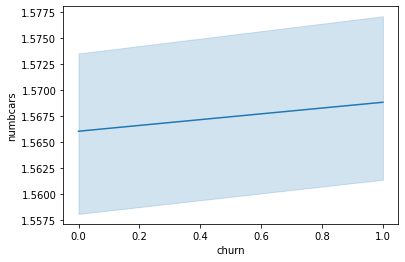

In [71]:
sns.lineplot(data=df,
            x='churn',
            y='numbcars');

In [72]:
df[['churn', 'numbcars']].corr(method='pearson')

,churn,numbcars
churn,1.000000,0.002233
numbcars,0.002233,1.000000


In [73]:
# correlação muito baixa, preenchendo com média simples

df.loc[df['numbcars'].isnull(), 'numbcars'] = df['numbcars'].mean()

#### ownrent

Diz se o cliente é dono ou aluga o imóvel, observado uma relação entre o cliente ser dono e o número de filhos, preenchido com regressão logística

In [730]:
# maioria dos registros na condição de "dono"

df['ownrent'].value_counts()

O    62572
R     1961
Name: ownrent, dtype: int64

In [74]:
# observando a média de filhos entre quem aluga e quem possuí imóvel

dfaux = df.copy()


dfaux = dfaux[['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'ownrent']]

dfaux['kid0_2'] = dfaux['kid0_2'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid3_5'] = dfaux['kid3_5'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid6_10'] = dfaux['kid6_10'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid11_15'] = dfaux['kid11_15'].apply(lambda x: 1 if(x == 'Y') else 0)
dfaux['kid16_17'] = dfaux['kid16_17'].apply(lambda x: 1 if(x == 'Y') else 0)

In [75]:
dfaux[['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'ownrent']].groupby('ownrent').mean()

,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17
ownrent,,,,,
O,0.056902,0.066758,0.118388,0.130753,0.147958
R,0.084141,0.100969,0.119327,0.102499,0.076492


***Pessoas que alugam a casa costumam ter filhos mais novos enquanto donos costumam ter filhos mais velhos***

In [77]:
# preenchendo com regressão logística baseado em número de filhos

x = dfaux.dropna()
x = x[['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'ownrent']]
y = x[['ownrent']]
x = x.drop('ownrent', axis=1)


xx = dfaux.loc[dfaux['ownrent'].isnull()]
xx = xx.drop('ownrent', axis = 1)

In [78]:
lr = LogisticRegression()

lr.fit(x, y)

dfaux['ownrent'].loc[dfaux['ownrent'].isnull()] = lr.predict(xx)

C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pedro\anaconda3\envs\DHAUZ Churn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [79]:
df['ownrent'] = dfaux['ownrent']

In [80]:
# feito

df['ownrent'].isnull().sum()

0

#### prizm_social_one

Refere-se ao "grupo social" qual aquele cliente pertence, há um grupo considerável de registros nulos (6424), irei passar algumas informações sobre cada individuo para uma RandomForestClassifier, e verificar se assertividade do modelo é suficiente para conservar os dados.

Mesmo usando um algorítimo robusto como a RandomForest, o modelo falha em identificar a classe social com mais de 50% de acurácia, assim como na abordagem com as colunas "dwllsize & dwlltype" irei observar qual a importância dessa variável futuramente, caso ela seja de extrema importância, irei fazer o preenchimento.

In [81]:
dfaux = df.copy()

In [82]:
# multiclass prediction

df['prizm_social_one'].value_counts()

S    30890
U    22627
C    16206
T    14391
R     4681
Name: prizm_social_one, dtype: int64

In [83]:
social_cols = ['kid0_2', 'kid3_5', 'kid6_10', 
               'kid11_15', 'kid16_17', 'ethnic', 
               'marital', 'adults', 'income', 
               'numbcars', 'lor', 'ownrent', 'area', 'prizm_social_one']

In [95]:
x = dfaux.dropna()
x = x[social_cols]
y = x[['prizm_social_one']]
x = x.drop('prizm_social_one', axis=1)

str_cols = x.select_dtypes('O').columns.tolist()

encoder = OneHotEncoder(top_categories=10, variables=str_cols, drop_last=False)
encoder.fit(x)

x = encoder.transform(x)

xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.30)

xx = dfaux[social_cols].loc[dfaux['prizm_social_one'].isnull()]

xx = xx.drop('prizm_social_one', axis = 1)

In [86]:
# baseline

base_line = xval
base_line['numbcars'] = 'S'
base_line = base_line['numbcars']

accuracy_score(yval, base_line)

0.3721564531104921

In [96]:
rf = RandomForestClassifier()

rf.fit(xtr, ytr)

prev = rf.predict(xval)

accuracy_score(yval, prev)

C:\Users\Pedro\AppData\Local\Temp/ipykernel_14864/3183356745.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(xtr, ytr)


0.38974001857010215

# Feature Importance

***A fase de feature importance será feita no começo do projeto, devido ao fato do Dataframe ser extramente esparço, e ao prazo para a entrega da solução ser curto, como foi explicado já na fase de limpeza***

## Modelagem para feature importance

***O foco não é uma modelagem precisa, e sim permitir que as variáveis sejam ranquados pelos métodos***

### Numéric